<a href="https://colab.research.google.com/github/chwdoit/BigData/blob/main/Tensorflow_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q tensorflow-gpu==2.0.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL   # 파이썬 이미지 라이브러리 pip install pillow
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.  # 255 -1~ 1, 0 ~ 1

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # 0보다 작을 경우 0.01을 곱해준다.

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

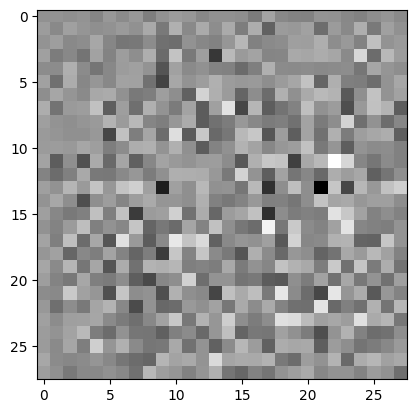

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00068713]], shape=(1, 1), dtype=float32)


In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다.
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

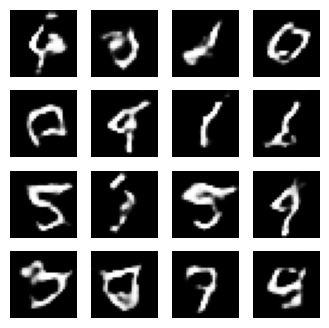

CPU times: user 2min 22s, sys: 31.1 s, total: 2min 53s
Wall time: 9min 25s


In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

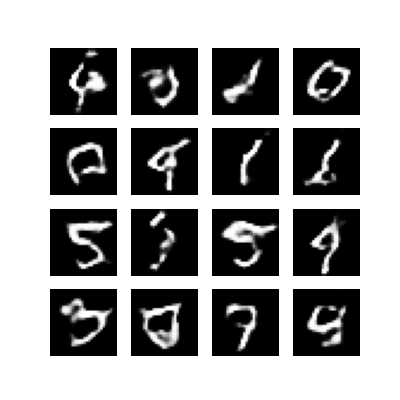

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-26-880e85e12649>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-26-880e85e12649>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>